***Data Preparation Phase***

11490434/11490434 [==============================] - 0s 0us/step


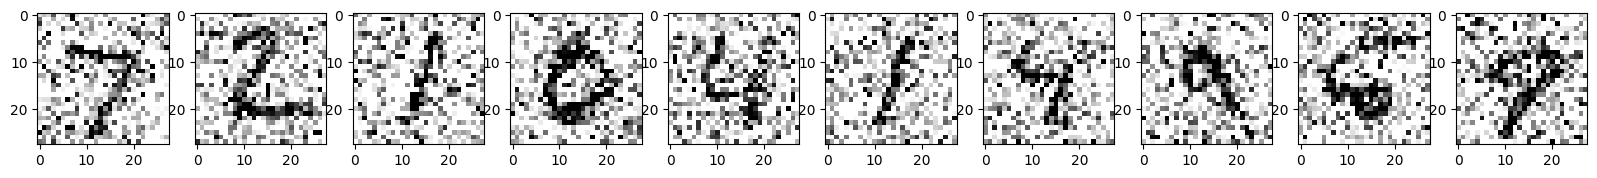

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add noise to the images
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

# Reshape the data to include the channel dimension
x_train_noisy = x_train_noisy[..., np.newaxis]
x_test_noisy = x_test_noisy[..., np.newaxis]
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

# Visualize the noisy images
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='binary')
plt.show()

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation

def build_denoising_model():
    input_img = Input(shape=(28, 28, 1))

    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Decoder
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

autoencoder = build_denoising_model()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496 

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# By using early stopping, you allow the model to train for the optimal number of epochs based on the validation loss, preventing overfitting and saving computation time.

# Train the model with early stopping
history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=100,  # Set a high number of epochs
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test),
                          callbacks=[early_stopping])


Epoch 1/100
469/469 [==============================] - 13s 13ms/step - loss: 0.1270 - val_loss: 0.1156
Epoch 2/100
469/469 [==============================] - 6s 13ms/step - loss: 0.0964 - val_loss: 0.0944
Epoch 3/100
469/469 [==============================] - 5s 11ms/step - loss: 0.0942 - val_loss: 0.0935
Epoch 4/100
469/469 [==============================] - 6s 12ms/step - loss: 0.0930 - val_loss: 0.0933
Epoch 5/100
469/469 [==============================] - 5s 11ms/step - loss: 0.0922 - val_loss: 0.0947
Epoch 6/100
469/469 [==============================] - 5s 10ms/step - loss: 0.0917 - val_loss: 0.0918
Epoch 7/100
469/469 [==============================] - 6s 12ms/step - loss: 0.0911 - val_loss: 0.0914
Epoch 8/100
469/469 [==============================] - 5s 10ms/step - loss: 0.0907 - val_loss: 0.0919
Epoch 9/100
469/469 [==============================] - 7s 14ms/step - loss: 0.0904 - val_loss: 0.0913
Epoch 10/100
469/469 [==============================] - 6s 12ms/step - loss: 0.09

In [5]:
# Save the model
autoencoder.save_weights('autoencoder_weights.h5')
autoencoder.save('autoencoder_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
# Save the training history
!pip install joblib
import joblib
joblib.dump(history.history, 'train_history.pkl')


['train_history.pkl']

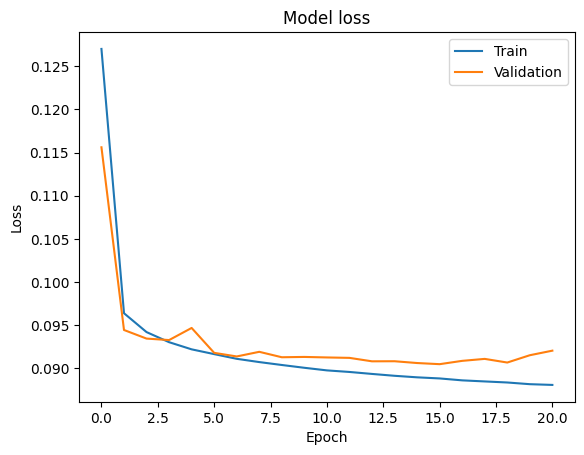

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

313/313 [==============================] - 2s 3ms/step


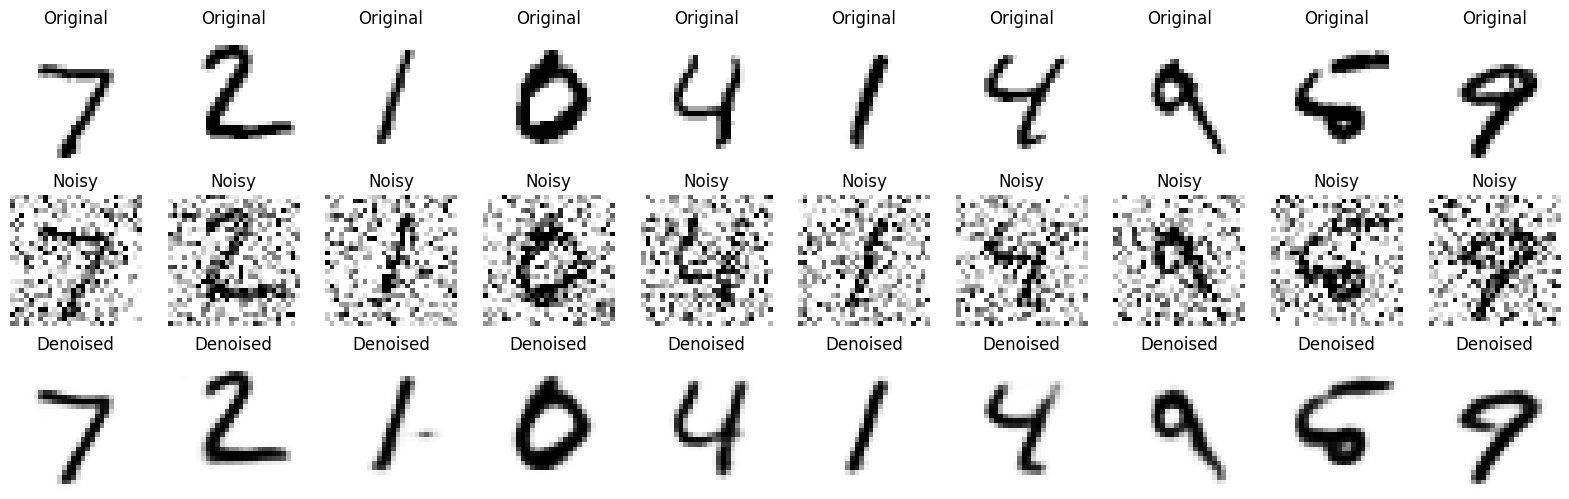

In [8]:
# Predict the denoised images
denoised_images = autoencoder.predict(x_test_noisy)

# Visualize the original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='binary')
    plt.title("Original")
    plt.axis('off')

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='binary')
    plt.title("Noisy")
    plt.axis('off')

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='binary')
    plt.title("Denoised")
    plt.axis('off')
plt.show()

In [9]:
# Additional Metrics: PSNR and SSIM
import tensorflow as tf
def psnr(target, ref):
    target_data = target.astype(np.float64)
    ref_data = ref.astype(np.float64)

    diff = ref_data - target_data
    diff = diff.flatten('C')
    rmse = np.sqrt(np.mean(diff ** 2.))

    return 20 * np.log10(1.0 / rmse)

def ssim(target, ref):
    return tf.image.ssim(target, ref, max_val=1.0)

psnr_values = [psnr(x_test[i], denoised_images[i]) for i in range(len(x_test))]
ssim_values = [ssim(x_test[i], denoised_images[i]).numpy() for i in range(len(x_test))]

print(f'Average PSNR: {np.mean(psnr_values)}')
print(f'Average SSIM: {np.mean(ssim_values)}')

# Save additional metrics
additional_metrics = {
    'psnr': psnr_values,
    'ssim': ssim_values
}
joblib.dump(additional_metrics, 'additional_metrics.pkl')

Average PSNR: 20.662410931895185
Average SSIM: 0.8821255564689636


['additional_metrics.pkl']

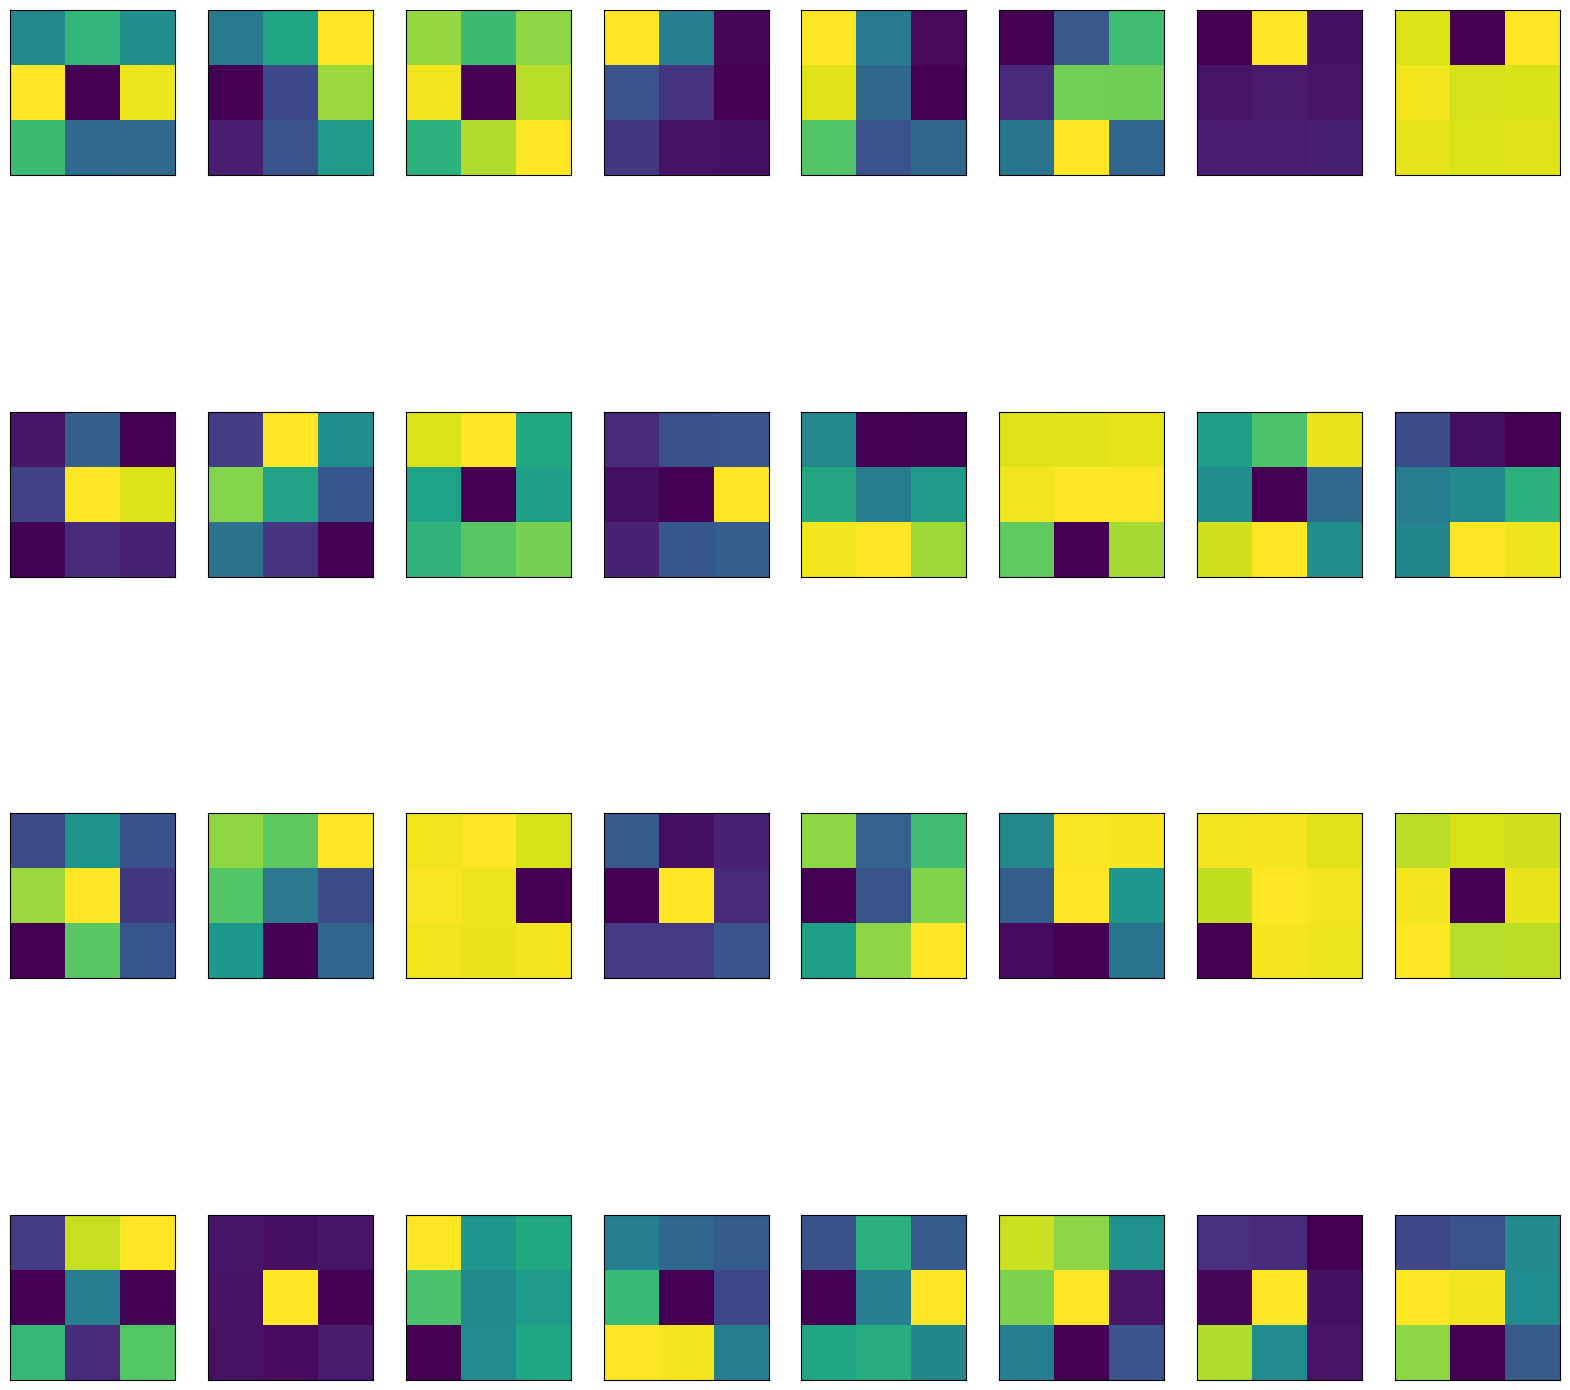

In [10]:
# Visualize the learned filters
def visualize_filters(model):
    filters, biases = model.layers[1].get_weights()
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    n_filters = filters.shape[3]
    n_columns = 8
    n_rows = n_filters // n_columns
    fig = plt.figure(figsize=(20, 20))
    for i in range(n_filters):
        ax = plt.subplot(n_rows, n_columns, i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(filters[:, :, 0, i], cmap='viridis')
    plt.show()

visualize_filters(autoencoder)

313/313 [==============================] - 2s 6ms/step


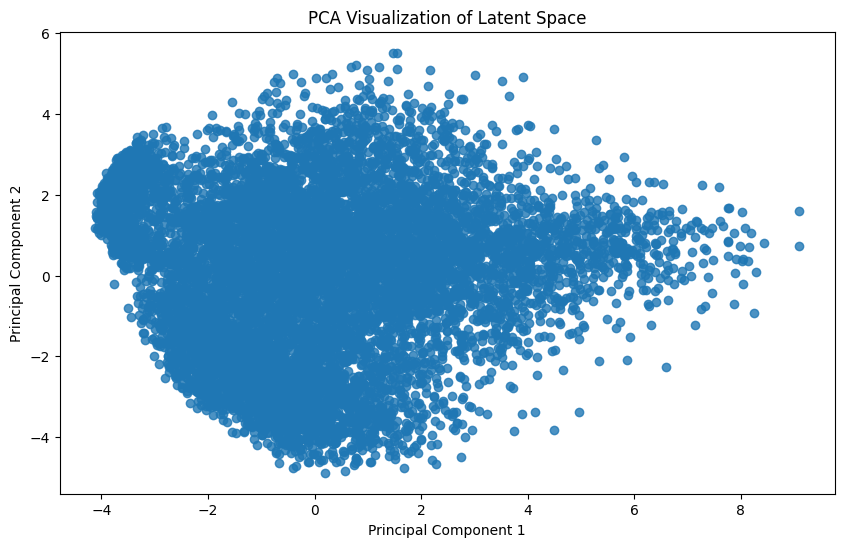

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
latent_space = autoencoder.predict(x_test_noisy)
latent_space = latent_space.reshape(latent_space.shape[0], -1)
latent_pca = pca.fit_transform(latent_space)

plt.figure(figsize=(10, 6))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.8)
plt.title('PCA Visualization of Latent Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

313/313 [==============================] - 1s 4ms/step


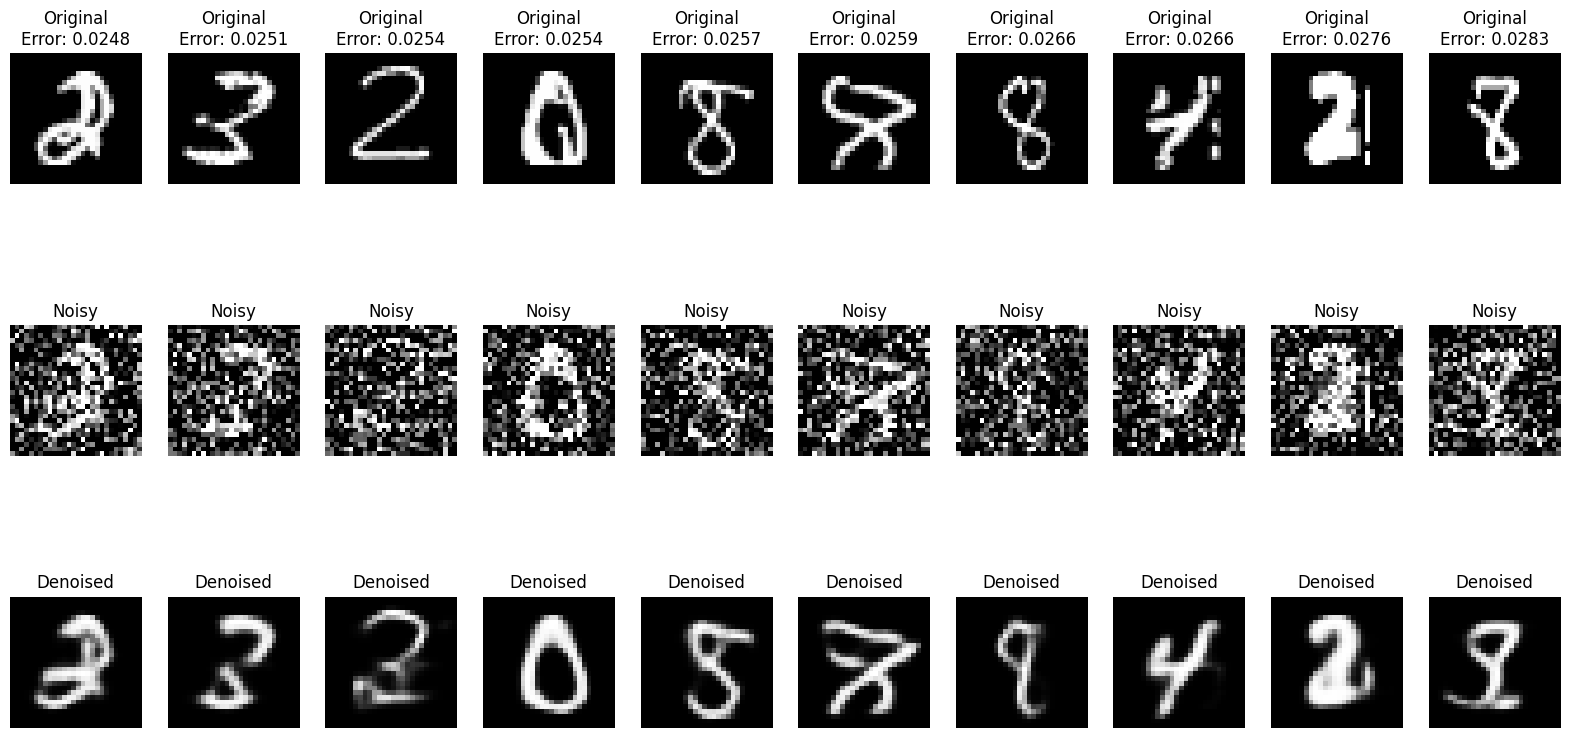

Mean Reconstruction Error: 0.0093
Median Reconstruction Error: 0.0091
Max Reconstruction Error: 0.0283
Min Reconstruction Error: 0.0008


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Function to compute MSE for all images
def compute_reconstruction_errors(x_original, x_denoised):
    errors = []
    for original, denoised in zip(x_original, x_denoised):
        error = mean_squared_error(original.flatten(), denoised.flatten())
        errors.append(error)
    return np.array(errors)

# Get denoised images from the model
denoised_images = autoencoder.predict(x_test_noisy)

# Compute reconstruction errors
reconstruction_errors = compute_reconstruction_errors(x_test, denoised_images)

# Identify the worst-case examples (highest errors)
worst_case_indices = np.argsort(reconstruction_errors)[-10:]  # Get top 10 worst cases

# Visualize the worst-case examples
def visualize_errors(worst_case_indices, x_test, x_test_noisy, denoised_images, errors):
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(worst_case_indices):
        # Original Image
        ax = plt.subplot(3, 10, i + 1)
        plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Original\nError: {errors[idx]:.4f}")
        plt.axis('off')

        # Noisy Image
        ax = plt.subplot(3, 10, i + 1 + 10)
        plt.imshow(x_test_noisy[idx].reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoised Image
        ax = plt.subplot(3, 10, i + 1 + 20)
        plt.imshow(denoised_images[idx].reshape(28, 28), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

    plt.show()

# Call the visualization function
visualize_errors(worst_case_indices, x_test, x_test_noisy, denoised_images, reconstruction_errors)

# Print summary statistics of errors
print(f"Mean Reconstruction Error: {np.mean(reconstruction_errors):.4f}")
print(f"Median Reconstruction Error: {np.median(reconstruction_errors):.4f}")
print(f"Max Reconstruction Error: {np.max(reconstruction_errors):.4f}")
print(f"Min Reconstruction Error: {np.min(reconstruction_errors):.4f}")

313/313 [==============================] - 1s 3ms/step


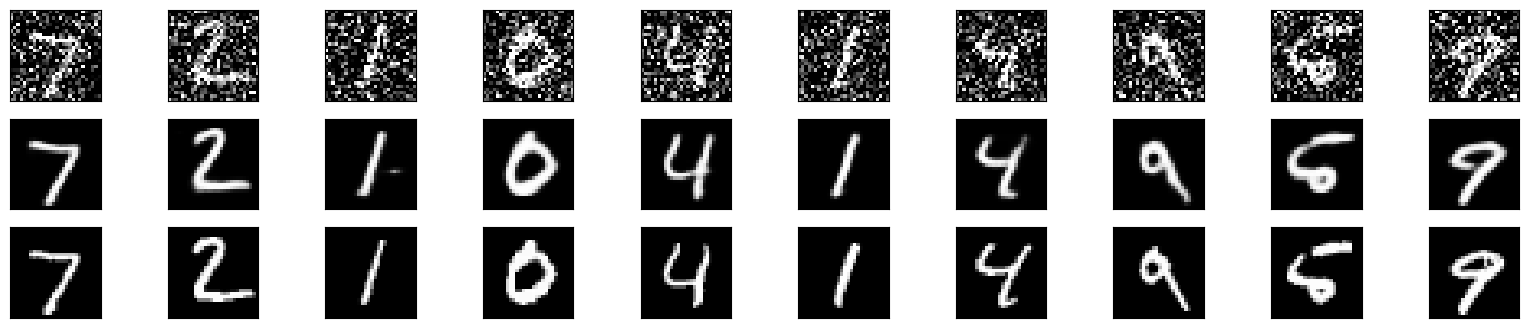

In [22]:
def plot_denoised_images(noisy_images, denoised_images, original_images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display noisy images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display denoised images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display original images
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Generate denoised images
denoised_images = autoencoder.predict(x_test_noisy)

# Plot the images
plot_denoised_images(x_test_noisy, denoised_images, x_test)

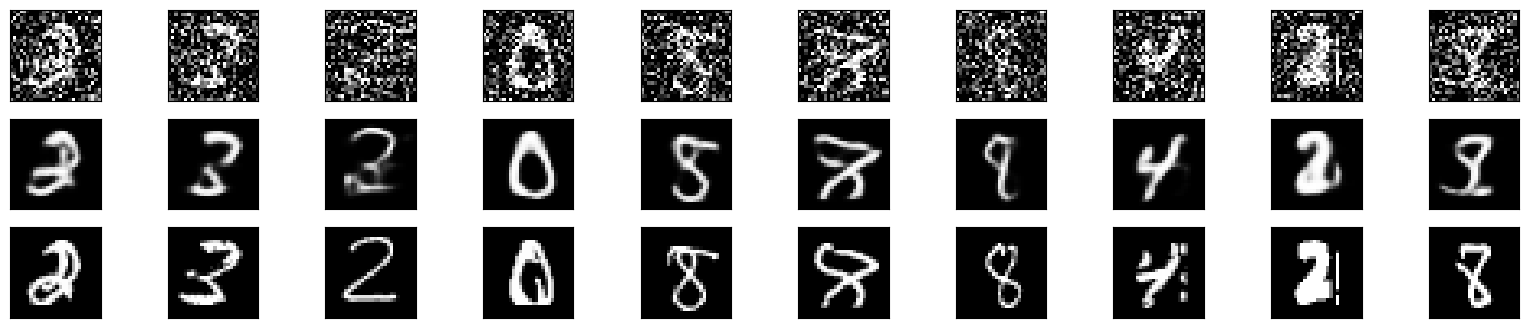

In [23]:
from sklearn.metrics import mean_squared_error

mse_scores = [mean_squared_error(x_test[i].flatten(), denoised_images[i].flatten()) for i in range(len(x_test))]
worst_indices = np.argsort(mse_scores)[-10:]  # Get indices of 10 worst denoised images

# Plot the worst-performing denoised images
plot_denoised_images(x_test_noisy[worst_indices], denoised_images[worst_indices], x_test[worst_indices])